Purpose: Develop code for random forest non-binary classification model.<br>
Author: Anna Pardo<br>
Date initiated: August 2, 2023

In [1]:
# load modules
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

In [6]:
def load_clean_data(path_to_tpm):
    """
    Args:
        path_to_tpm = full path to file containing raw TPM, columns for Sample, BioProject, & Treatment
        single_stress = a single stressor to which the data must be subsetted, or "none" (default)
    """
    # load the TPM data
    raw_tpm = pd.read_csv(path_to_tpm,sep="\t",header="infer")
    # replace DroughtRepeat with Drought
    raw_tpm["Treatment"].mask(raw_tpm["Treatment"]=="DroughtRepeat","Drought",inplace=True)
    # labeling: set Control to 0 and stressors to 1-6
    slabels = {"Control":0,"Drought":1,"Cold":2,"Heat":3,"Flooding":4,"Low_Nitrogen":5,"Salt":6}
    proxy = []
    for i in range(len(raw_tpm.index)):
        t = raw_tpm.iloc[i,raw_tpm.columns.get_loc("Treatment")]
        proxy.append(slabels[t])
    raw_tpm["Label"] = proxy
    # return the dataframe
    return raw_tpm

In [4]:
def variance_threshold_selector(data):
    selector = VarianceThreshold()
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def check_if_balanced(labeled_tpm):
    """
    Args:
        labeled_tpm = raw TPM with columns for Sample, BioProject, Label, Treatment
    """
    if labeled_tpm["Label"].value_counts()[0] == labeled_tpm["Label"].value_counts()[1]:
        return True
    else:
        return False

def downsample(dataframe):
    """
    Args:
        dataframe = a log TPM dataframe with a Label column and Sample set as the index
    """
    # generate a variable of value counts
    vc = dataframe["Label"].value_counts()

    # subset data to only samples labeled 1
    ones_only = dataframe[dataframe["Label"]==1]

    # downsample from the subsetted dataframe
    ds = ones_only.sample(n=vc[1],random_state=42)

    # subset original data to control samples
    zeroes = dataframe[dataframe["Label"]==0]

    # concatenate controls and downsampled stress samples
    downsampled = pd.concat([ds,zeroes])
    # return dataframe
    return downsampled

In [5]:
def pre_split_transform(raw_tpm,balanced,downsample=False):
    """
    Args:
        raw_tpm = dataframe containing raw TPM values, columns for Sample, BioProject, Treatment, Label
        balanced = Boolean variable, True or False (result of check_if_balanced())
        downsample = Boolean variable, True or False, default False (set manually outside function)
    """
    # if data have treatment column, drop it
    #if "Treatment" in raw_tpm.columns:
    #    raw_tpm = raw_tpm.drop("Treatment",axis=1)
    # temporarily, set index to Sample and drop BioProject, Label, & Treatment columns
    blt = raw_tpm[["Sample","BioProject","Treatment","Label"]]
    tpmi = raw_tpm.set_index("Sample").drop(["BioProject","Treatment","Label"],axis=1)
    # remove zero-variance genes
    vttpm = variance_threshold_selector(tpmi)
    # log-transform TPM
    vttpm_log = vttpm.apply(lambda x: np.log2(x+1))
    # downsample data if needed
    if balanced!=True:
        if downsample==True:
            # add back labels
            vttpm_log = blt[["Sample","Label"]].merge(vttpm_log.reset_index().rename(columns={"index":"Sample"}))
            # set Sample as index
            vttpm_log = vttpm_log.set_index("Sample")
            # downsample the data
            vttpm_log = downsample(vttpm_log)
    # add treatment, labels, and BioProject back in, set Sample as the index again
    labeled = blt.merge(vttpm_log.reset_index().rename(columns={"index":"Sample"}))
    labeled.set_index("Sample",inplace=True)
    # drop rows containing NaN values
    labeled = labeled.dropna(axis=0)
    # return dataframe
    return labeled

In [7]:
tpm = load_clean_data("../../data/rawtpm_bptreat_noPEG.tsv")
tpm.head()

,Sample,BioProject,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030,Label
0,SRR11933261,PRJNA637522,Drought,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,...,0.000000,0.0,0.0,0.0,0.309501,0.0,0.000000,0.0,0.000000,1
1,SRR11933272,PRJNA637522,Drought,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,...,0.127878,0.0,0.0,0.0,6.703281,0.0,0.000000,0.0,0.000000,1
2,SRR11933250,PRJNA637522,Drought,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,...,0.000000,0.0,0.0,0.0,0.417565,0.0,0.254123,0.0,1.213349,1
3,SRR11933029,PRJNA637522,Control,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.370075,0
4,SRR11933040,PRJNA637522,Drought,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,...,0.012158,0.0,0.0,0.0,9.625225,0.0,0.000000,0.0,2.352959,1


In [11]:
len(tpm["BioProject"].unique())

39

In [12]:
# data exploration: what is the distribution of sample number per BioProject for each treatment?
## start for flooding
flood = tpm[tpm["Treatment"]=="Flooding"]

In [13]:
bp = []
nsamp = []
for b in flood["BioProject"].unique():
    bp.append(b)
    df = flood[flood["BioProject"]==b]
    nsamp.append(len(df["Sample"].unique()))
plotdf = pd.DataFrame(list(zip(bp,nsamp)),columns=["BioProject","N_samples"])
plotdf

,BioProject,N_samples
0,PRJNA267717,24
1,PRJNA606824,18
2,PRJNA687609,6


In [16]:
percent = []
totalsamp = sum(plotdf["N_samples"])
for i in list(plotdf["N_samples"]):
    percent.append((i/totalsamp)*100)
plotdf["Percent_of_total_samples"] = percent
plotdf

,BioProject,N_samples,Percent_of_total_samples
0,PRJNA267717,24,50.0
1,PRJNA606824,18,37.5
2,PRJNA687609,6,12.5


<BarContainer object of 3 artists>

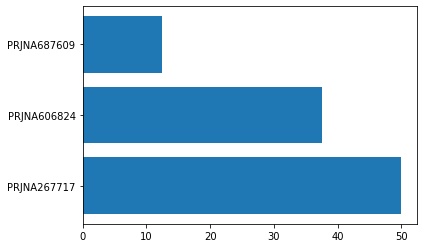

In [17]:
plt.barh(plotdf["BioProject"],plotdf["Percent_of_total_samples"])

In [23]:
# make a dataframe with information about BioProjects. columns: Treatment, BioProject, number of samples, percent of total samples
## make this for each treatment, including control, then combine them
def bioproject_info(treatment,indf):
    # subset initial dataframe
    df = indf[indf["Treatment"]==treatment]
    bp = list(df["BioProject"].unique())
    treat = []
    nsamp = []
    psamp = []
    totalsamp = len(df["Sample"].unique())
    for b in bp:
        treat.append(treatment)
        bdf = df[df["BioProject"]==b]
        ns = len(bdf["Sample"].unique())
        ps = (ns/totalsamp)*100
        nsamp.append(ns)
        psamp.append(ps)
    # bind into dataframe
    outdf = pd.DataFrame(list(zip(treat,bp,nsamp,psamp)),columns=["Treatment","BioProject","N_samples","Percent"])
    return outdf

In [38]:
testdf = bioproject_info("Heat",tpm)
testdf

,Treatment,BioProject,N_samples,Percent
0,Heat,PRJNA506720,3,1.604278
1,Heat,PRJNA244661,9,4.812834
2,Heat,PRJNA747925,57,30.481283
3,Heat,PRJNA520822,40,21.390374
4,Heat,PRJNA548548,7,3.743316
5,Heat,PRJNA791560,18,9.625668
6,Heat,PRJNA349117,35,18.716578
7,Heat,PRJNA646054,18,9.625668


In [39]:
sum(testdf["N_samples"])

187

(array([33.,  0.,  3.,  1.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 0.12376238,  2.93316832,  5.74257426,  8.5519802 , 11.36138614,
        14.17079208, 16.98019802, 19.78960396, 22.5990099 , 25.40841584,
        28.21782178]),
 <BarContainer object of 10 artists>)

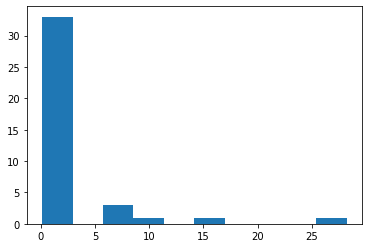

In [37]:
plt.hist(testdf["Percent"])